In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
ngpu= 1
print(torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu"))
print(torch.cuda.get_device_name(0))

1.8.1+cu101
True
cuda:0
NVIDIA GeForce RTX 2060


In [2]:
import torch.nn as nn
from complexPyTorch.complexLayers import ComplexConv2d, ComplexMaxPool2d, ComplexReLU
from complexPyTorch.complexFunctions import complex_relu, complex_max_pool2d, complex_upsample

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        ComplexConv2d(in_channels, out_channels, 3, padding=1),
        ComplexReLU(),
        ComplexConv2d(out_channels, out_channels, 3, padding=1),
        ComplexReLU()
    )

def coe_to_spatial(img):
    iimage = torch.fft.ifft2(img)
    iimage = torch.abs(iimage)
    
    iimage -= torch.min(iimage)
    iimage /= torch.max(iimage)
    return iimage

## main model

In [3]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.dconv_down1 = double_conv(3, 32)
        self.dconv_down2 = double_conv(32, 64)
        self.dconv_down3 = double_conv(64, 128)

        self.dconv_down4 = double_conv(128, 256)
   
        self.dconv_up3 = double_conv(128 + 256, 128)
        self.dconv_up2 = double_conv(64 + 128, 64)
        self.dconv_up1 = double_conv(32 + 64, 32)

        self.conv_last = ComplexConv2d(32, n_class, 1)
        self.conv_llast = ComplexConv2d(3, 1, 1)
        self.maxpool = ComplexMaxPool2d(2)
        '''
        maxpool用於下採樣
        upsample用於上採樣
        '''
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = complex_upsample(x, scale_factor=2, mode='bilinear', align_corners=True)   
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = complex_upsample(x, scale_factor=2, mode='bilinear', align_corners=True)     
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = complex_upsample(x, scale_factor=2, mode='bilinear', align_corners=True)       
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        return out

def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            # apply a uniform distribution to the weights and a bias=0
            m.weight.data.uniform_(0.0, 1.0)
            m.bias.data.fill_(0)

<p>繪製model:<p>

<pre><code>from torchviz import make_dot
x = torch.randn(1, 3, 256, 256).requires_grad_(True).cuda()
y = model(x)
vis_graph = make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))
vis_graph.view()
</code></pre>

<p>輸出 Model parameters:
<pre><code> 
model = UNet(n_class=3).cuda()
for name, param in model.named_parameters():
     print(param)
</code></pre>

## training loop

In [4]:
from collections import defaultdict
import torch.nn.functional as F
from tqdm.notebook import tqdm
from tensorboardX import SummaryWriter
from lossfunction import FocalFrequencyLoss, MSELoss
def train_model(model, optimizer, scheduler, num_epochs=25):
    
    log_path = os.path.join(os.getcwd(), "log/log-complex-mse")
    if not os.path.exists(log_path):
        os.makedirs(log_path)
        
    net_path = os.path.join(os.getcwd(), "net/net-complex-mse")
    if not os.path.exists(net_path):
        os.makedirs(net_path)
    
    writer = SummaryWriter(log_path)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for param_group in optimizer.param_groups:
            print('LR', param_group['lr'])
            
        since = time.time()
        ###################
        # train the model #
        ###################
        model.train()
        
        train_loss = []
        epoch_samples = 0
        with torch.set_grad_enabled(True):
            for (image, label) in tqdm(dataloaders['train']):
                # print('images, labels', images, labels)
                image, label = image.to(device), label.to(device)
                images, labels = image.to(torch.cfloat), label.to(torch.cfloat)
                
                optimizer.zero_grad(set_to_none=True)
                
                outputs = model(images)
                
                # ffl = FocalFrequencyLoss(loss_weight=1.0, alpha=1.0)
                # loss = ffl(outputs, labels)
                
                mse = MSELoss()
                loss = mse(outputs, labels)
                

                train_loss.append(loss.data.cpu().numpy() * images.size(0))
            
                loss.backward()
                optimizer.step()
                # scheduler.step()

                epoch_samples += images.size(0)
            
            print('training: total loss: {:.6f}'.format(sum(train_loss) / epoch_samples))
            writer.add_scalar('Training/Loss', sum(train_loss) / epoch_samples, epoch)

        model.eval()
        val_loss = []
        with torch.no_grad():
            epoch_samples = 0
            for (image, label) in tqdm(dataloaders['val']):
                image, label = image.to(device), label.to(device)
                images, labels = image.to(torch.cfloat), label.to(torch.cfloat)

                outputs = model(images)
                metrics = defaultdict(float)
                
                # ffl = FocalFrequencyLoss(loss_weight=1.0, alpha=1.0)
                # loss = ffl(outputs, labels)
                
                mse = MSELoss()
                loss = mse(outputs, labels)

                val_loss.append(loss.data.cpu().numpy() * images.size(0))
                
                epoch_samples += images.size(0)
                
            print('validation: total loss: {:.6f}'.format(sum(val_loss) / epoch_samples))
            writer.add_scalar('Validation/Loss', sum(val_loss) / epoch_samples, epoch)
            epoch_loss = sum(val_loss) / epoch_samples
            
            torch.save(model, net_path + '/net-' + str(epoch+1) + '.pkl')
            if  epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from dataloader import get_train_augmentation, get_test_augmentation, get_loader
import torchvision
from torchvision import transforms, datasets, models
import os

tr_img_folder = os.path.join(r'C:\Users\user\pythonProject\mission87\data\DUTS\DUTS-TR\DUTS-TR-Image')
tr_gt_folder = os.path.join(r'C:\Users\user\pythonProject\mission87\data\DUTS\DUTS-TR\DUTS-TR-Mask')

ver = 2
train_transform = get_train_augmentation(img_size=224, ver=ver)
# test_transform = get_test_augmentation(img_size=224, ver=ver)

train_loader = get_loader(tr_img_folder, tr_gt_folder, phase='train',
                          batch_size=2, shuffle=True, num_workers=4,
                          transform=train_transform)
val_loader = get_loader(tr_img_folder, tr_gt_folder, phase='val',
                        batch_size=2, shuffle=False, num_workers=4,
                        transform=train_transform)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

model = UNet(n_class=3).cuda()
model.apply(weights_init)
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

train length : 10025
val length : 528


## model test complex

In [ ]:
test = torch.randn([1, 3, 224, 224])
test = test.to(torch.cfloat) #dtype to complex64
test = test.cuda()

pred = model(test)
loss = mse_loss(test, pred)
print(loss)
loss.backward()

## check training/valid data

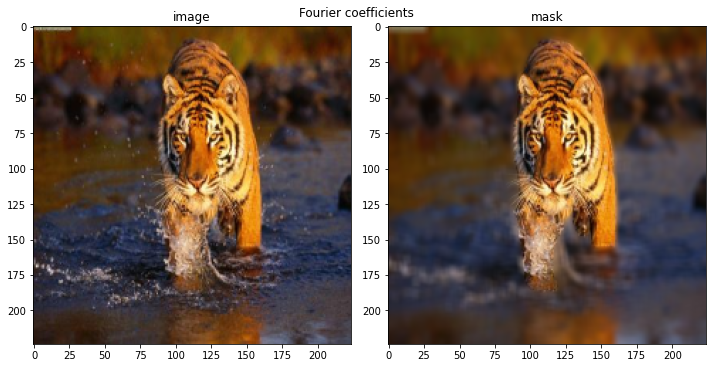

In [6]:
import matplotlib.pyplot as plt
image, mask = next(iter(train_loader))

s = {1: 'Nothing change', 2: 'Fourier coefficients', 3: 'Fourier amplitude', 4: 'Fourier phase'}
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(s[ver], verticalalignment='bottom')
ax1.imshow(coe_to_spatial(image[0].to(torch.cfloat)).permute(1, 2, 0))
ax1.set_title('image')
ax2.imshow(coe_to_spatial(mask[0].to(torch.cfloat)).permute(1, 2, 0), 'gray')
ax2.set_title('mask')
fig.tight_layout()
fig.subplots_adjust(top=0.99)
plt.show()

In [7]:
image = image.to(torch.cfloat).cuda()
mask = mask.cuda()
pred = model(image)

mse = MSELoss()
loss = mse(pred, mask)
print(loss)

loss.backward()

tensor(4057.0961, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)


In [9]:
ffl = FocalFrequencyLoss(loss_weight=1.0, alpha=1.0)
print(ffl)

image = image.to(torch.cfloat).cuda()
mask = mask.cuda()
pred = model(image)
loss = ffl(pred, mask)
print(loss)

loss.backward()

FocalFrequencyLoss()
tensor(6097.0405, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)


# Start Training

In [11]:
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
LR 0.001



training: total loss: 182.699842



validation: total loss: 30.040855
saving best model
15m 17s
Epoch 1/49
----------
LR 0.001



training: total loss: 35.695283



validation: total loss: 22.578296
saving best model
15m 16s
Epoch 2/49
----------
LR 0.001



training: total loss: 23.521903



validation: total loss: 27.222905
15m 9s
Epoch 3/49
----------
LR 0.001



training: total loss: 19.785306



validation: total loss: 18.881529
saving best model
15m 4s
Epoch 4/49
----------
LR 0.001



training: total loss: 16.593227



validation: total loss: 17.635695
saving best model
15m 1s
Epoch 5/49
----------
LR 0.001



training: total loss: 13.647052



validation: total loss: 14.254259
saving best model
15m 5s
Epoch 6/49
----------
LR 0.001



training: total loss: 20.781448



validation: total loss: 22.798473
15m 11s
Epoch 7/49
----------
LR 0.001



training: total loss: 14.849303



validation: total loss: 12.156498
saving best model
15m 13s
Epoch 8/49
----------
LR 0.001



training: total loss: 12.719275



validation: total loss: 10.214867
saving best model
14m 34s
Epoch 9/49
----------
LR 0.001



training: total loss: 11.850204



validation: total loss: 9.403524
saving best model
14m 33s
Epoch 10/49
----------
LR 0.001



training: total loss: 11.047362



validation: total loss: 9.833585
14m 22s
Epoch 11/49
----------
LR 0.001



training: total loss: 10.405443



validation: total loss: 10.629132
14m 18s
Epoch 12/49
----------
LR 0.001



training: total loss: 10.390933



validation: total loss: 9.751378
14m 30s
Epoch 13/49
----------
LR 0.001



training: total loss: 9.894427



validation: total loss: 10.546768
16m 29s
Epoch 14/49
----------
LR 0.001



training: total loss: 9.782356



validation: total loss: 9.849410
16m 41s
Epoch 15/49
----------
LR 0.001



training: total loss: 9.178188



validation: total loss: 8.132950
saving best model
16m 21s
Epoch 16/49
----------
LR 0.001



training: total loss: 9.211656



validation: total loss: 8.561535
16m 23s
Epoch 17/49
----------
LR 0.001



training: total loss: 9.266371



validation: total loss: 7.843621
saving best model
15m 24s
Epoch 18/49
----------
LR 0.001



training: total loss: 8.811044



validation: total loss: 7.874234
16m 3s
Epoch 19/49
----------
LR 0.001



training: total loss: 9.060325



validation: total loss: 7.983893
15m 53s
Epoch 20/49
----------
LR 0.001



training: total loss: 9.253427



validation: total loss: 8.110310
16m 6s
Epoch 21/49
----------
LR 0.001



training: total loss: 8.379309



validation: total loss: 7.777454
saving best model
16m 4s
Epoch 22/49
----------
LR 0.001



training: total loss: 8.805490



validation: total loss: 7.826874
15m 39s
Epoch 23/49
----------
LR 0.001



training: total loss: 8.446070



validation: total loss: 8.194716
15m 37s
Epoch 24/49
----------
LR 0.001



training: total loss: 8.247499



validation: total loss: 7.861935
15m 38s
Epoch 25/49
----------
LR 0.001



training: total loss: 8.382256



validation: total loss: 7.284060
saving best model
15m 44s
Epoch 26/49
----------
LR 0.001



training: total loss: 8.186214



validation: total loss: 7.696757
14m 31s
Epoch 27/49
----------
LR 0.001



training: total loss: 8.478327



validation: total loss: 7.845921
14m 18s
Epoch 28/49
----------
LR 0.001



training: total loss: 8.321492



validation: total loss: 7.152651
saving best model
14m 17s
Epoch 29/49
----------
LR 0.001



training: total loss: 7.917438



validation: total loss: 7.014802
saving best model
14m 18s
Epoch 30/49
----------
LR 0.001



training: total loss: 8.260216



validation: total loss: 7.606160
14m 18s
Epoch 31/49
----------
LR 0.001



training: total loss: 8.137144



validation: total loss: 7.608089
14m 18s
Epoch 32/49
----------
LR 0.001



training: total loss: 8.491007



validation: total loss: 7.942059
14m 18s
Epoch 33/49
----------
LR 0.001



training: total loss: 7.875200



validation: total loss: 7.231921
14m 18s
Epoch 34/49
----------
LR 0.001



training: total loss: 8.068205



validation: total loss: 7.176066
14m 18s
Epoch 35/49
----------
LR 0.001



training: total loss: 7.995656



validation: total loss: 8.021745
14m 18s
Epoch 36/49
----------
LR 0.001



training: total loss: 7.831614



validation: total loss: 6.905638
saving best model
14m 18s
Epoch 37/49
----------
LR 0.001



training: total loss: 8.047516



validation: total loss: 7.355996
14m 16s
Epoch 38/49
----------
LR 0.001



training: total loss: 7.874897



validation: total loss: 6.999714
14m 18s
Epoch 39/49
----------
LR 0.001



training: total loss: 7.736853



validation: total loss: 10.971797
14m 18s
Epoch 40/49
----------
LR 0.001



training: total loss: 7.984714



validation: total loss: 7.799320
14m 18s
Epoch 41/49
----------
LR 0.001



training: total loss: 7.785740



validation: total loss: 7.164698
14m 18s
Epoch 42/49
----------
LR 0.001



training: total loss: 7.779879



validation: total loss: 7.514242
14m 18s
Epoch 43/49
----------
LR 0.001



training: total loss: 9.096027



validation: total loss: 7.380741
14m 18s
Epoch 44/49
----------
LR 0.001



training: total loss: 8.101035



validation: total loss: 6.986065
14m 18s
Epoch 45/49
----------
LR 0.001



training: total loss: 8.234158



validation: total loss: 7.499761
14m 18s
Epoch 46/49
----------
LR 0.001



training: total loss: 7.737203



validation: total loss: 7.782015
14m 15s
Epoch 47/49
----------
LR 0.001



training: total loss: 8.504483



validation: total loss: 7.858453
14m 15s
Epoch 48/49
----------
LR 0.001



training: total loss: 7.757825



validation: total loss: 7.554598
14m 18s
Epoch 49/49
----------
LR 0.001



training: total loss: 8.230218



validation: total loss: 7.574075
14m 18s
Best val loss: 6.905638


# Eval

In [9]:
te_img_folder = os.path.join(r'C:\Users\user\pythonProject\mission87\data\DUTS\DUTS-TE\DUTS-TE-Image')
te_gt_folder = os.path.join(r'C:\Users\user\pythonProject\mission87\data\DUTS\DUTS-TE\DUTS-TE-Mask')

ver = 2
test_transform = get_test_augmentation(img_size=224, ver=ver)

test_loader = get_loader(te_img_folder, te_gt_folder, phase='test',
                          batch_size=1, shuffle=True, num_workers=4,
                          transform=test_transform)

model = torch.load(r'C:\Users\User\pythonProject\mission87\net\net-complex\net-50.pkl')

test length : 5019


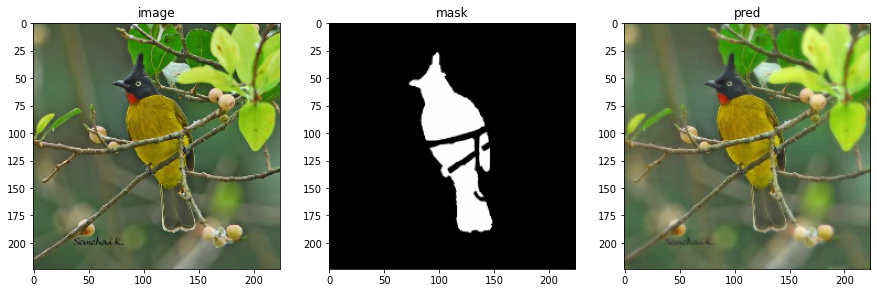

In [33]:
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    image, mask = next(iter(test_loader))
    image, mask = image.to(torch.cfloat).cuda(), mask.to(torch.cfloat).cuda()
    pred = model(image)
    
    image_ = coe_to_spatial(image[0]).permute(1, 2, 0).cpu().numpy()
    mask_ = coe_to_spatial(mask[0]).permute(1, 2, 0).cpu().numpy()
    pred_ = coe_to_spatial(pred[0]).permute(1, 2, 0).cpu().detach().numpy()
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    ax1.imshow(image_)
    ax1.set_title('image')
    ax2.imshow(mask_)
    ax2.set_title('mask')
    ax3.imshow(pred_)
    ax3.set_title('pred')
    plt.show()

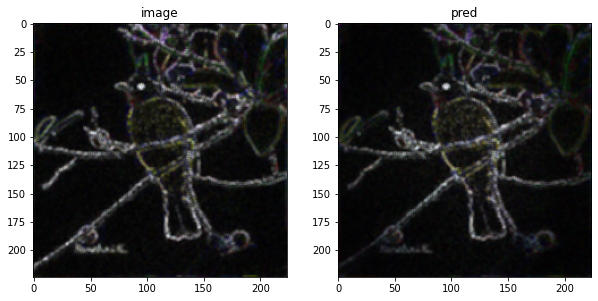

In [34]:
import numpy as np
import cv2
def Spectral_residual(inputdata):
	fourier = np.fft.fft2(inputdata) #做傅立葉轉換
	fourier_shift= np.fft.fftshift(fourier) #對變換結果做順序調整
	Logf = np.log(np.abs(fourier_shift)) #求 log spectrum L(f) (得振幅譜)
	Pf = np.angle(fourier_shift) #求相位圖

	Af = cv2.blur(Logf,(3,3)) #使用 blur套件協助處理 equation (3)的 local linearity
	Rf = Logf - Af #spectral residual

	inverse_fourier = np.fft.ifftshift(np.exp(Rf + 1j*Pf)) #回復順序
	inverse_fourier = np.fft.ifft2(inverse_fourier) #反傅立葉
	inverse_fourier = np.abs(inverse_fourier)

	saliency = cv2.GaussianBlur(inverse_fourier, (3,3), 5) #做平滑，有更好的視覺效果

	return saliency
def normalize(x): 
    ## f(.)
    return (x-np.min(x))/(np.max(x)-np.min(x))

def sr(img):
    saliency_r = Spectral_residual(img[:,:,0])
    saliency_g = Spectral_residual(img[:,:,1])
    saliency_b = Spectral_residual(img[:,:,2])
    saliency_map = normalize(np.stack((saliency_r,saliency_g,saliency_b), axis=-1))
    return saliency_map
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
# fig.suptitle(s[ver], verticalalignment='bottom')
ax1.imshow(sr(image_))
ax1.set_title('image')
ax2.imshow(sr(pred_))
ax2.set_title('pred')
plt.show()